In [2]:
using RCall
using LightGraphs
using GraphPlot
using Colors

In [3]:
function kron_δ(i,j)
    if i == j
        return 1
    else
        return 0
    end
end

kron_δ (generic function with 1 method)

# La NBM de KRZAKALA

In [4]:
red = readdlm("zacharykarateclub.dat")
g = Graph()
ultimovertice = Int64(maximum(red))
add_vertices!(g,ultimovertice)
for n in 1:Int64((length(red)/2))
    add_edge!(g,Int64(red[n,1]),Int64(red[n,2]))
end

In [5]:
function la_NBM(g::SimpleGraph)
    edgeidmap = Dict{Edge, Int}()
    m = 0
    for e in edges(g)
        m += 1
        edgeidmap[e] = m
    end
    
    if !is_directed(g)
        for e in edges(g)
            m += 1
            edgeidmap[reverse(e)] = m
        end
    end

    
    B = zeros(Float64, m, m)
    
    
    for (e,u) in edgeidmap
        i, j = src(e), dst(e)
        for k in in_neighbors(g,i)
            for l in in_neighbors(g,k)
                v = edgeidmap[Edge(k,l)]
                B[v, u] = kron_δ(i,l)*(1-kron_δ(j,k))
            end
        end
    end

    return B, edgeidmap
end

la_NBM (generic function with 1 method)

In [6]:
function contrae(g,v)
    y = zeros(Float64, nv(g))
    for i in 1:nv(g)
        for j in neighbors(g,i)
            u = la_NBM(g)[2][Edge(j,i)]
            y[i] += v[u]
            y[j] += v[u]
        end
    end
    y
end

contrae (generic function with 1 method)

In [9]:
function nonBM_embedding(g, k)
    NB = la_NBM(g)[1]
    eigv = eigvecs(NB)
    λ = eigvals(NB)
    los_reales = Array(Float64,0)
    los_indices_reales = Array(Int64,0)
    for i in 1:length(λ)
        if imag(λ[i]) == 0 && real(λ[i]) != 0
            push!(los_reales,λ[i])
            push!(los_indices_reales,i)
        end
    end
    los_que_sirven = view(real(eigv),:,los_indices_reales)
    ϕ = zeros(Float64, nv(g), k)
    for n=1:k
        v= los_que_sirven[:,n]
        ϕ[:,n] = contrae(g, v)
    end
    return ϕ, los_reales , los_que_sirven
end

nonBM_embedding (generic function with 1 method)

In [10]:
los_que_sirven = nonBM_embedding(g,14)[1]

34×14 Array{Float64,2}:
 -2.53087    2.15729    -1.61308    …  -2.99066e-15  -5.69423e-16
 -1.43242    1.06344    -0.657698      -2.67841e-15   1.94289e-16
 -1.76309    0.415829   -0.163982      -4.52416e-15  -1.52656e-16
 -0.934199   0.834237   -0.527288      -2.87097e-15  -3.60822e-16
 -0.249967   0.439019   -0.470131       6.14092e-16   2.56739e-16
 -0.293343   0.583336   -0.664761   …   1.10328e-15   3.88578e-16
 -0.293343   0.583336   -0.664761       9.92262e-16   1.55084e-15
 -0.632043   0.54926    -0.343878      -9.71445e-16  -2.77556e-17
 -0.865557  -0.178283    0.124516      -3.02883e-15  -1.84575e-15
 -0.286974  -0.0895687   0.075128      -7.84095e-16   2.13371e-16
 -0.249967   0.439019   -0.470131   …   6.245e-16    -6.245e-16  
 -0.124718   0.122474   -0.0973398     -5.24143e-16   1.86123e-16
 -0.247362   0.279847   -0.20683       -1.02392e-15  -9.57567e-16
  ⋮                                 ⋱                            
 -0.275569  -0.275783    0.1974        -2.63678e-16 

In [11]:
R_kmeans = R"kmeans";

function membresia(g,n)
    membresia = Array(Int64,0)
    if n == 2
        for i in 1:length(los_que_sirven[:,2])
            if sign(los_que_sirven[i,2]) == sign(1)
                push!(membresia,1)
            else
                push!(membresia,2)
            end
        end
    else 
        matriz_sirve = los_que_sirven
        cluster_p = R_kmeans(matriz_sirve[:,2:n],n,nstart=500)
        for i in 1:length(cluster_p[1])
            push!(membresia,cluster_p[1][i])
        end
    end
    membresia
end

function dibujar(g,n,i)
    membership = membresia(g,n)
    nodecolor = collect(distinguishable_colors(n,colorant"red"))
    nodefillc = nodecolor[membership]
    nodelabel = collect(1:nv(g))
    if i == 1
        gplot(g, nodefillc=nodefillc,layout=spring_layout)#, nodelabel=nodelabel)
    elseif i == 2
        gplot(g, nodefillc=nodefillc,layout=spectral_layout)#, nodelabel=nodelabel)
    elseif i == 3
        gplot(g, nodefillc=nodefillc,layout=circular_layout)#, nodelabel=nodelabel)
    end        
end

dibujar (generic function with 1 method)

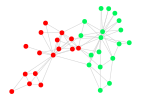

In [12]:
dibujar(g,2,1)

In [10]:
sum(la_NBM(g)[1])

1056.0

# LA FLOW DE NEWMAN

In [13]:
##### Para cargar la red ####

red = readdlm("dolphins.dat")
g = Graph()
ultimovertice = Int64(maximum(red))
add_vertices!(g,ultimovertice)
for n in 1:Int64((length(red)/2))
    add_edge!(g,Int64(red[n,1]),Int64(red[n,2]))
end

In [14]:
function inv_degree_N(g,i)
    if degree(g,i) != 1
        1/(degree(g,i)-1)
    else
        1/degree(g,i)
    end
end

inv_degree_N (generic function with 1 method)

In [15]:
function la_NBM(g::SimpleGraph)
    edgeidmap = Dict{Edge, Int}()
    m = 0
    for e in edges(g)
        m += 1
        edgeidmap[e] = m
    end
    
    if !is_directed(g)
        for e in edges(g)
            m += 1
            edgeidmap[reverse(e)] = m
        end
    end

    
    B = zeros(Float64, m, m)
    
    
    for (e,u) in edgeidmap
        i, j = src(e), dst(e)
        for k in in_neighbors(g,i)
            for l in in_neighbors(g,k)
                v = edgeidmap[Edge(k,l)]
                B[v, u] = (kron_δ(i,l)*(1-kron_δ(j,k)))*inv_degree_N(g,i)
            end
        end
    end

    return B, edgeidmap
end

la_NBM (generic function with 1 method)

In [16]:
function contrae(g,v)
    y = zeros(Float64, nv(g))
    for i in 1:nv(g)
        for j in neighbors(g,i)
            u = la_NBM(g)[2][Edge(j,i)]
            y[i] += v[u]
            y[j] += v[u]
        end
    end
    y
end

contrae (generic function with 1 method)

In [18]:
function nonBM_embedding(g, k)
    NB = la_NBM(g)[1]
    eigv = eigvecs(NB)
    λ = eigvals(NB)
    los_reales = Array(Float64,0)
    los_indices_reales = Array(Int64,0)
    for i in 1:length(λ)
        if imag(λ[i]) == 0 && real(λ[i]) != 0
            push!(los_reales,λ[i])
            push!(los_indices_reales,i)
        end
    end
    los_que_sirven = view(real(eigv),:,los_indices_reales)
    ϕ = zeros(Float64, nv(g), k)
    for n=1:k
        v= los_que_sirven[:,n]
        ϕ[:,n] = contrae(g, v)
    end
    return ϕ, los_reales , los_que_sirven
end

nonBM_embedding (generic function with 1 method)

In [19]:
los_que_sirven = nonBM_embedding(g,14)[1]

62×14 Array{Float64,2}:
 -0.75784    -0.2937      0.289236   -0.2351     …   0.0351153    0.211113   
 -0.83299     1.09253     0.51199    -0.299871      -0.00808278  -0.0515805  
 -0.511228   -0.255845    0.454169   -0.0136849     -0.0185555    0.0828077  
 -0.378644   -0.173155   -0.199873   -0.0683007      0.0233406    0.000686281
 -0.055606   -0.0330104  -0.0918038  -0.0379307      0.0767668   -0.0744411  
 -0.34699     0.870519   -0.327763    0.229059   …   0.0854926   -0.0270733  
 -0.524558    1.24449    -0.413018    0.319124       0.084625    -0.0449924  
 -0.562502    0.511884    0.487714   -0.244936       0.00651728   0.0109108  
 -0.751161   -0.280572   -0.232541   -0.160603      -0.046795    -0.0659793  
 -0.576599    1.40147    -0.450536    0.336292      -0.0516799   -0.0497533  
 -0.628605   -0.256643    0.4355     -0.203037   …   0.0143449    0.100442   
 -0.055606   -0.0330104  -0.0918038  -0.0379307      0.0767668   -0.0744411  
 -0.0629795  -0.0384704   0.0218748   0.

In [20]:
R_kmeans = R"kmeans";

function membresia(g,n)
    membresia = Array(Int64,0)
    if n == 2
        for i in 1:length(los_que_sirven[:,2])
            if sign(los_que_sirven[i,2]) == sign(1)
                push!(membresia,1)
            else
                push!(membresia,2)
            end
        end
    else 
        matriz_sirve = los_que_sirven
        cluster_p = R_kmeans(matriz_sirve[:,2:n],n,nstart=500)
        for i in 1:length(cluster_p[1])
            push!(membresia,cluster_p[1][i])
        end
    end
    membresia
end

function dibujar(g,n,i)
    membership = membresia(g,n)
    nodecolor = collect(distinguishable_colors(n,colorant"red"))
    nodefillc = nodecolor[membership]
    nodelabel = collect(1:nv(g))
    if i == 1
        gplot(g, nodefillc=nodefillc,layout=spring_layout)#, nodelabel=nodelabel)
    elseif i == 2
        gplot(g, nodefillc=nodefillc,layout=spectral_layout)#, nodelabel=nodelabel)
    elseif i == 3
        gplot(g, nodefillc=nodefillc,layout=circular_layout)#, nodelabel=nodelabel)
    end        
end

dibujar (generic function with 1 method)

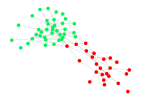

In [21]:
dibujar(g,2,1)

# Operador reluctante

In [22]:
##### Para cargar la red ####

red = readdlm("zacharykarateclub.dat")
g = Graph()
ultimovertice = Int64(maximum(red))
add_vertices!(g,ultimovertice)
for n in 1:Int64((length(red)/2))
    add_edge!(g,Int64(red[n,1]),Int64(red[n,2]))
end

In [23]:
function inv_degree(g,i)
    1/degree(g,i)
end

inv_degree (generic function with 1 method)

In [24]:
function la_NBM(g::SimpleGraph)
    edgeidmap = Dict{Edge, Int}()
    m = 0
    for e in edges(g)
        m += 1
        edgeidmap[e] = m
    end
    
    if !is_directed(g)
        for e in edges(g)
            m += 1
            edgeidmap[reverse(e)] = m
        end
    end

    
    B = zeros(Float64, m, m)
    
    
    for (e,u) in edgeidmap
        i, j = src(e), dst(e)
        for k in in_neighbors(g,i)
            for l in in_neighbors(g,k)
                v = edgeidmap[Edge(k,l)]
                #B[v, u] = ((kron_δ(i,l)*(1-kron_δ(j,k)))+(kron_δ(i,l)*kron_δ(j,k)*inv_degree(g,j)))
                #B[v, u] = ((kron_δ(j,k)*(1-kron_δ(l,i)))*inv_degree(g,i))+(kron_δ(i,l)*kron_δ(j,k)*inv_degree(g,j))
                B[v, u] = (kron_δ(j,k)*(1-kron_δ(l,i)))+(kron_δ(j,k)*kron_δ(l,i)*inv_degree(g,j))
            end
        end
    end

    return B, edgeidmap
end

la_NBM (generic function with 1 method)

In [25]:
function contrae(g,v)
    y = zeros(Float64, nv(g))
    for i in 1:nv(g)
        for j in neighbors(g,i)
            u = la_NBM(g)[2][Edge(j,i)]
            y[i] += v[u]
            y[j] += v[u]
        end
    end
    y
end

contrae (generic function with 1 method)

In [26]:
function nonBM_embedding(g, k)
    NB = la_NBM(g)[1]
    eigv = eigvecs(NB)
    λ = eigvals(NB)
    los_reales = Array(Float64,0)
    los_indices_reales = Array(Int64,0)
    for i in 1:length(λ)
        if imag(λ[i]) == 0 && real(λ[i]) != 0
            push!(los_reales,λ[i])
            push!(los_indices_reales,i)
        end
    end
    los_que_sirven = view(real(eigv),:,los_indices_reales)
    ϕ = zeros(Float64, nv(g), k)
    for n=1:k
        v= los_que_sirven[:,n]
        ϕ[:,n] = contrae(g, v)
    end
    return ϕ, los_reales , los_que_sirven
end

nonBM_embedding (generic function with 1 method)

In [27]:
los_que_sirven = nonBM_embedding(g,6)[1]

34×6 Array{Float64,2}:
 2.59753   -2.46761   -1.15823    -0.0582696    -0.0431257     0.128329  
 1.39976   -1.18362   -0.415517   -0.0288596    -0.0398647    -0.0415295 
 1.72895   -0.540433  -0.10858    -0.0237173     0.0559248    -0.0324955 
 0.902835  -0.892207  -0.326333   -0.0171276    -0.00511692    0.0151088 
 0.252572  -0.40331   -0.380016   -0.0124589    -0.0091191     0.0263609 
 0.294056  -0.516436  -0.565535   -0.0171065    -0.0124832     0.0357861 
 0.294056  -0.516436  -0.565535   -0.0171065    -0.0124832     0.0357861 
 0.613582  -0.592587  -0.213419   -0.0124084    -0.0026234     0.00452962
 0.862312   0.179133   0.0881457   0.000238255   0.00585915   -0.00312352
 0.298893   0.103021   0.0607556   0.00821511    0.0039725    -0.00326145
 0.252572  -0.40331   -0.380016   -0.0124589    -0.0091191     0.0263609 
 0.142751  -0.158493  -0.0778255  -0.00360178   -0.00265881    0.00785744
 0.252254  -0.303341  -0.141447   -0.00663781   -0.00372222    0.0109959 
 ⋮             

In [28]:
R_kmeans = R"kmeans";

function membresia(g,n)
    membresia = Array(Int64,0)
    if n == 2
        for i in 1:length(los_que_sirven[:,2])
            if sign(los_que_sirven[i,2]) == sign(1)
                push!(membresia,1)
            else
                push!(membresia,2)
            end
        end
    else 
        matriz_sirve = los_que_sirven
        cluster_p = R_kmeans(matriz_sirve[:,2:n],n,nstart=20)
        for i in 1:length(cluster_p[1])
            push!(membresia,cluster_p[1][i])
        end
    end
    membresia
end

function dibujar(g,n,i)
    membership = membresia(g,n)
    nodecolor = collect(distinguishable_colors(n,colorant"red"))
    nodefillc = nodecolor[membership]
    nodelabel = collect(1:nv(g))
    if i == 1
        gplot(g, nodefillc=nodefillc,layout=spring_layout)#, nodelabel=nodelabel)
    elseif i == 2
        gplot(g, nodefillc=nodefillc,layout=spectral_layout)#, nodelabel=nodelabel)
    elseif i == 3
        gplot(g, nodefillc=nodefillc,layout=circular_layout)#, nodelabel=nodelabel)
    end        
end

dibujar (generic function with 1 method)

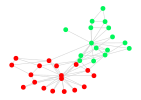

In [30]:
dibujar(g,2,1)

In [435]:
sum(la_NBM(g)[1])

12049.0

# Reluctante normalizado

In [31]:
##### Para cargar la red ####

red = readdlm("dolphins.dat")
g = Graph()
ultimovertice = Int64(maximum(red))
add_vertices!(g,ultimovertice)
for n in 1:Int64((length(red)/2))
    add_edge!(g,Int64(red[n,1]),Int64(red[n,2]))
end

In [32]:
function inv_degree(g,i)
    1/degree(g,i)
end

inv_degree (generic function with 1 method)

In [33]:
function la_NBM(g::SimpleGraph)
    edgeidmap = Dict{Edge, Int}()
    m = 0
    for e in edges(g)
        m += 1
        edgeidmap[e] = m
    end
    
    if !is_directed(g)
        for e in edges(g)
            m += 1
            edgeidmap[reverse(e)] = m
        end
    end

    
    B = zeros(Float64, m, m)
    
    
    for (e,u) in edgeidmap
        i, j = src(e), dst(e)
        for k in in_neighbors(g,i)
            for l in in_neighbors(g,k)
                v = edgeidmap[Edge(k,l)]
                B[v, u] = ((kron_δ(i,l)*(1-kron_δ(j,k)))+(kron_δ(i,l)*kron_δ(j,k)*inv_degree(g,j)))*(1/((degree(g,i)-1)+inv_degree(g,j)))
            end
        end
    end

    return B, edgeidmap
end

la_NBM (generic function with 1 method)

In [34]:
function contrae(g,v)
    y = zeros(Float64, nv(g))
    for i in 1:nv(g)
        for j in neighbors(g,i)
            u = la_NBM(g)[2][Edge(j,i)]
            y[i] += v[u]
            y[j] += v[u]
        end
    end
    y
end

contrae (generic function with 1 method)

In [35]:
function nonBM_embedding(g, k)
    NB = la_NBM(g)[1]
    eigv = eigvecs(NB)
    λ = eigvals(NB)
    los_reales = Array(Float64,0)
    los_indices_reales = Array(Int64,0)
    for i in 1:length(λ)
        if imag(λ[i]) == 0 && real(λ[i]) != 0
            push!(los_reales,λ[i])
            push!(los_indices_reales,i)
        end
    end
    los_que_sirven = view(real(eigv),:,los_indices_reales)
    ϕ = zeros(Float64, nv(g), k)
    for n=1:k
        v= los_que_sirven[:,n]
        ϕ[:,n] = contrae(g, v)
    end
    return ϕ, los_reales , los_que_sirven
end

nonBM_embedding (generic function with 1 method)

In [36]:
los_que_sirven = nonBM_embedding(g,14)[1]

62×14 Array{Float64,2}:
 -0.66244   -0.361862   -0.304331    -0.153487   …   0.183945    -0.0216752  
 -0.881875   0.853456   -0.879581    -0.630098       0.0810684   -7.23407e-5 
 -0.461995  -0.296728   -0.394027     0.330185       0.186458    -0.226201   
 -0.340948  -0.206314    0.0736544   -0.113404       0.0163733   -0.022706   
 -0.119058  -0.0918974   0.214666    -0.199785      -0.0433468    0.101134   
 -0.458527   0.810455    0.4508       0.317795   …  -0.0339904    0.0171568  
 -0.664992   1.11764     0.372636     0.268597      -0.0144966    0.0231223  
 -0.559522   0.352411   -0.676125    -0.386667       0.112908    -0.00226092 
 -0.665517  -0.349596    0.0268292   -0.256779       0.0451096    0.0192297  
 -0.772933   1.34258     0.668045     0.488046       0.00248937  -0.000416014
 -0.558753  -0.31811    -0.384135    -0.0314975  …   0.207893     0.115335   
 -0.119058  -0.0918974   0.214666    -0.199785      -0.0433468    0.101134   
 -0.119181  -0.090867   -0.0177419    0.

In [37]:
R_kmeans = R"kmeans";

function membresia(g,n)
    membresia = Array(Int64,0)
    if n == 2
        for i in 1:length(los_que_sirven[:,2])
            if sign(los_que_sirven[i,2]) == sign(1)
                push!(membresia,1)
            else
                push!(membresia,2)
            end
        end
    else 
        matriz_sirve = los_que_sirven
        cluster_p = R_kmeans(matriz_sirve[:,2:n],n,nstart=500)
        for i in 1:length(cluster_p[1])
            push!(membresia,cluster_p[1][i])
        end
    end
    membresia
end

function dibujar(g,n,i)
    membership = membresia(g,n)
    nodecolor = collect(distinguishable_colors(n,colorant"navy"))
    nodefillc = nodecolor[membership]
    nodelabel = collect(1:nv(g))
    if i == 1
        gplot(g, nodefillc=nodefillc,layout=spring_layout)#, nodelabel=nodelabel)
    elseif i == 2
        gplot(g, nodefillc=nodefillc,layout=spectral_layout)#, nodelabel=nodelabel)
    elseif i == 3
        gplot(g, nodefillc=nodefillc,layout=circular_layout)#, nodelabel=nodelabel)
    end        
end

dibujar (generic function with 1 method)

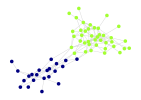

In [38]:
dibujar(g,2,1)

In [ ]:
sum(la_NBM(g)[1])

# Con la Laplaciana

In [2]:
##### Para cargar la red ####

red = readdlm("zacharykarateclub.dat")
g = Graph()
ultimovertice = Int64(maximum(red))
add_vertices!(g,ultimovertice)
for n in 1:Int64((length(red)/2))
    add_edge!(g,Int64(red[n,1]),Int64(red[n,2]))
end

In [3]:
#A = full(adjacency_matrix(g))
A = full(laplacian_matrix(g))
los_que_sirven = eigvecs(A)

34x34 Array{Float64,2}:
 0.171499   0.112137   -0.0694042   -0.0718187  …  -0.940932     0.193749  
 0.171499   0.0412879  -0.0951475   -0.194548       0.0658648    0.00522422
 0.171499  -0.023219   -0.0427041   -0.0988111      0.115069     0.0291861 
 0.171499   0.0554998  -0.105843    -0.212178       0.054758    -0.00929126
 0.171499   0.284605    0.121266     0.0311305      0.0582879   -0.0112534 
 0.171499   0.323727    0.201676     0.0990576  …   0.0633978   -0.012156  
 0.171499   0.323727    0.201676     0.0990576      0.0633978   -0.012156  
 0.171499   0.052586   -0.101302    -0.20082        0.05402     -0.0154823 
 0.171499  -0.0516013  -0.0146771   -0.0463439      0.0595377   -0.0799336 
 0.171499  -0.0928009  -0.0131195   -0.0899003     -0.0210499   -0.0602766 
 0.171499   0.284605    0.121266     0.0311305  …   0.0582879   -0.0112534 
 0.171499   0.210993   -0.764765     0.5745         0.0586062   -0.0113061 
 0.171499   0.109461   -0.160667    -0.324571       0.0588618   

In [4]:
R_kmeans = R"kmeans";

function membresia(g,n)
    membresia = Array(Int64,0)
    if n == 2
        for i in 1:length(los_que_sirven[:,2])
            if sign(los_que_sirven[i,2]) == sign(1)
                push!(membresia,1)
            else
                push!(membresia,2)
            end
        end
    else 
        matriz_sirve = los_que_sirven
        cluster_p = R_kmeans(matriz_sirve[:,2:n],n,nstart=500)
        for i in 1:length(cluster_p[1])
            push!(membresia,cluster_p[1][i])
        end
    end
    membresia
end

function dibujar(g,n,i)
    membership = membresia(g,n)
    nodecolor = collect(distinguishable_colors(n,colorant"red"))
    nodefillc = nodecolor[membership]
    nodelabel = collect(1:nv(g))
    if i == 1
        gplot(g, nodefillc=nodefillc,layout=spring_layout)#, nodelabel=nodelabel)
    elseif i == 2
        gplot(g, nodefillc=nodefillc,layout=spectral_layout)#, nodelabel=nodelabel)
    elseif i == 3
        gplot(g, nodefillc=nodefillc,layout=circular_layout)#, nodelabel=nodelabel)
    end        
end

dibujar (generic function with 1 method)

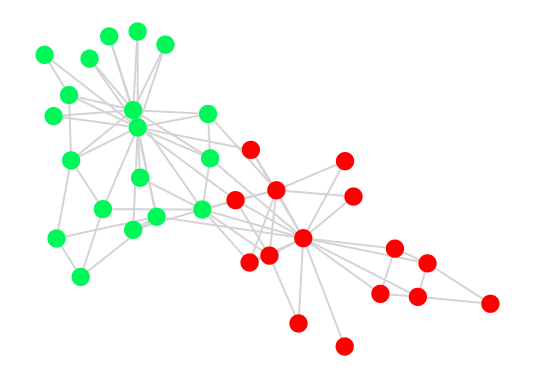

In [5]:
dibujar(g,2,1)

# Laplaciana dirigida

In [39]:
g = random_regular_digraph(34, 4)

{34, 136} directed graph

In [102]:
# La matriz de transición

"""
function trans_matrix(g)
    adj = full(adjacency_matrix(g))
    tm = (adj)*0.0
    for i in 1:nv(g)
        tm[i,:] = adj[i,:]/outdegree(g,i)
    end
    tm
end
"""
function trans_matrix(g)
    adj = full(adjacency_matrix(g))
    tm = (adj)*0.0
    for i in 1:nv(g)
        if outdegree(g,i) != 0
            tm[i,:] = adj[i,:]/outdegree(g,i)
        end
    end
    tm
end


## Hay que definir M = la suma de los pesos de todas las aristas.

function prob_mat(g)
    M = 2 * sum(ne(g)) #* suma de los pesos de todas las aristas
    pm = eye(nv(g))
    for i in 1:nv(g)
        pm[i,i] = degree(g,i)
    end
    pm = (1/M) * pm
end


function pro_mat(g)
    diagm(pagerank(g))
end


function laplacian_d(g)
    Π = prob_mat(g)
    P = trans_matrix(g)
    lm = eye(nv(g)) - ((Π^(1/2)*P*Π^(-1/2) + Π^(-1/2)*P'*Π^(1/2))/2)
end

laplacian_d (generic function with 1 method)

In [103]:
A = laplacian_d(g)

34x34 Array{Float64,2}:
  1.0        0.0       -0.153093  …   0.0        0.0        0.0     
  0.0        1.0        0.0           0.0        0.0        0.0     
 -0.153093   0.0        1.0           0.0        0.0        0.0     
  0.0        0.0        0.0          -0.125      0.0       -0.156696
  0.0        0.0        0.0           0.0        0.0       -0.163663
  0.0        0.0        0.0       …   0.0        0.0        0.0     
  0.0        0.0       -0.102062      0.0        0.0        0.0     
  0.0        0.0        0.0          -0.114983   0.0       -0.262071
  0.0        0.0        0.0           0.0        0.0        0.0     
  0.0        0.0        0.0           0.0        0.0        0.0     
 -0.176777   0.0       -0.144338  …   0.0        0.0        0.0     
  0.0        0.0        0.0           0.0        0.0        0.0     
  0.0        0.0        0.0           0.0       -0.176777   0.0     
  ⋮                               ⋱                                 
  0.0     

In [104]:
los_que_sirven = eigvecs(A)

34x34 Array{Float64,2}:
 -0.0847477   0.178523    0.0646409  -0.23348     …   0.089007    0.00952062
 -0.110676   -0.0881183   0.102192   -0.0535048      -0.15948     0.026077  
 -0.109485    0.148283    0.250216   -0.149159       -0.253099    0.0513694 
 -0.216548    0.251116   -0.257666    0.315955        0.187179    0.261447  
 -0.245202   -0.368616   -0.0181266  -0.04479         0.0411115   0.322633  
 -0.162523    0.145876    0.112875    0.449022    …   0.143109   -0.0947508 
 -0.170503    0.0403052   0.0576849  -0.139036        0.0708724  -0.158634  
 -0.300523   -0.0118334  -0.343847   -0.0213242       0.237371    0.391353  
 -0.0998702   0.178614    0.255578   -0.118898       -0.164369    0.0604027 
 -0.157416    0.0133156  -0.192389    0.235669       -0.186804   -0.251904  
 -0.121709    0.301653    0.175903   -0.224688    …   0.10324    -0.00869255
 -0.17306     0.0365511  -0.0883348  -0.176957       -0.0710712  -0.203685  
 -0.173267   -0.304283    0.0751618  -0.150783      

In [105]:
R_kmeans = R"kmeans";

function membresia(g,n)
    membresia = Array(Int64,0)
    if n == 2
        for i in 1:length(los_que_sirven[:,2])
            if sign(los_que_sirven[i,2]) == sign(1)
                push!(membresia,1)
            else
                push!(membresia,2)
            end
        end
    else 
        matriz_sirve = los_que_sirven
        cluster_p = R_kmeans(matriz_sirve[:,2:n],n,nstart=500)
        for i in 1:length(cluster_p[1])
            push!(membresia,cluster_p[1][i])
        end
    end
    membresia
end

function dibujar(g,n,i)
    membership = membresia(g,n)
    nodecolor = collect(distinguishable_colors(n,colorant"red"))
    nodefillc = nodecolor[membership]
    nodelabel = collect(1:nv(g))
    if i == 1
        gplot(g, nodefillc=nodefillc,layout=spring_layout)#, nodelabel=nodelabel)
    elseif i == 2
        gplot(g, nodefillc=nodefillc,layout=spectral_layout)#, nodelabel=nodelabel)
    elseif i == 3
        gplot(g, nodefillc=nodefillc,layout=circular_layout)#, nodelabel=nodelabel)
    end        
end

dibujar (generic function with 1 method)

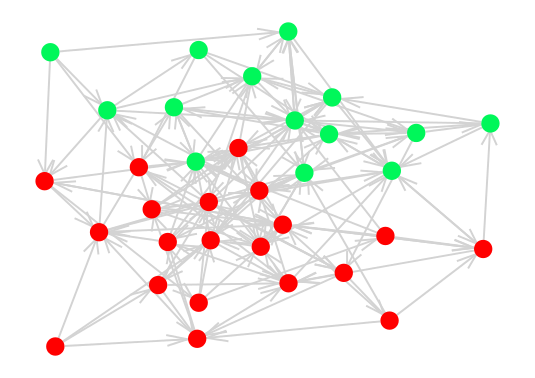

In [110]:
dibujar(g,2,1)

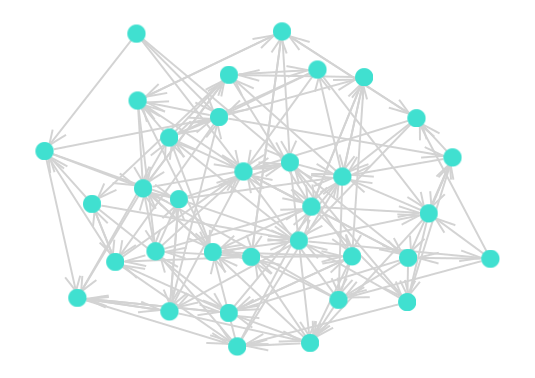

In [96]:
gplot(g)